# Azure LLM inference traces
The trace description can be found [here](https://github.com/Azure/AzurePublicDataset/blob/master/AzureLLMInferenceDataset2024.md).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
TRACE_NAMES = [
    "Coding",
    "Conversation",
]

In [3]:
TRACE_FILENAMES = [
    "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_code_1week.csv",
    "https://azurepublicdatasettraces.blob.core.windows.net/azurellminfererencetrace/AzureLLMInferenceTrace_conv_1week.csv",
]

In [4]:
# Read all traces
df_traces = {}
for trace_name, trace_filename in zip(TRACE_NAMES, TRACE_FILENAMES):
    # We need to use mixed format because we have both:
    # 2024-05-12 00:00:00.001163+00:00 and 2024-05-12 00:00:00+00:00
    # This is pretty expensive and there are probably better ways to handle this
    df_traces[trace_name] = pd.read_csv(trace_filename, parse_dates=["TIMESTAMP"], date_format="mixed", dayfirst=False)

In [5]:
df_traces["Coding"]

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-10 00:00:00.009930+00:00,2162,5
1,2024-05-10 00:00:00.017335+00:00,2399,6
2,2024-05-10 00:00:00.022314+00:00,76,15
3,2024-05-10 00:00:00.037845+00:00,2376,1
4,2024-05-10 00:00:00.083890+00:00,7670,8
...,...,...,...
16803690,2024-05-16 23:59:59.886489+00:00,897,1
16803691,2024-05-16 23:59:59.925267+00:00,2842,79
16803692,2024-05-16 23:59:59.928444+00:00,378,56
16803693,2024-05-16 23:59:59.928698+00:00,491,1


In [6]:
df_traces["Conversation"]

,TIMESTAMP,ContextTokens,GeneratedTokens
0,2024-05-12 00:00:00.001163+00:00,1452,3
1,2024-05-12 00:00:00.041683+00:00,584,3
2,2024-05-12 00:00:00.157988+00:00,862,38
3,2024-05-12 00:00:00.158932+00:00,1569,3
4,2024-05-12 00:00:00.248279+00:00,617,104
...,...,...,...
27303994,2024-05-18 23:59:59.759803+00:00,1224,11
27303995,2024-05-18 23:59:59.790078+00:00,283,56
27303996,2024-05-18 23:59:59.909045+00:00,336,8
27303997,2024-05-18 23:59:59.925224+00:00,3152,264


Coding


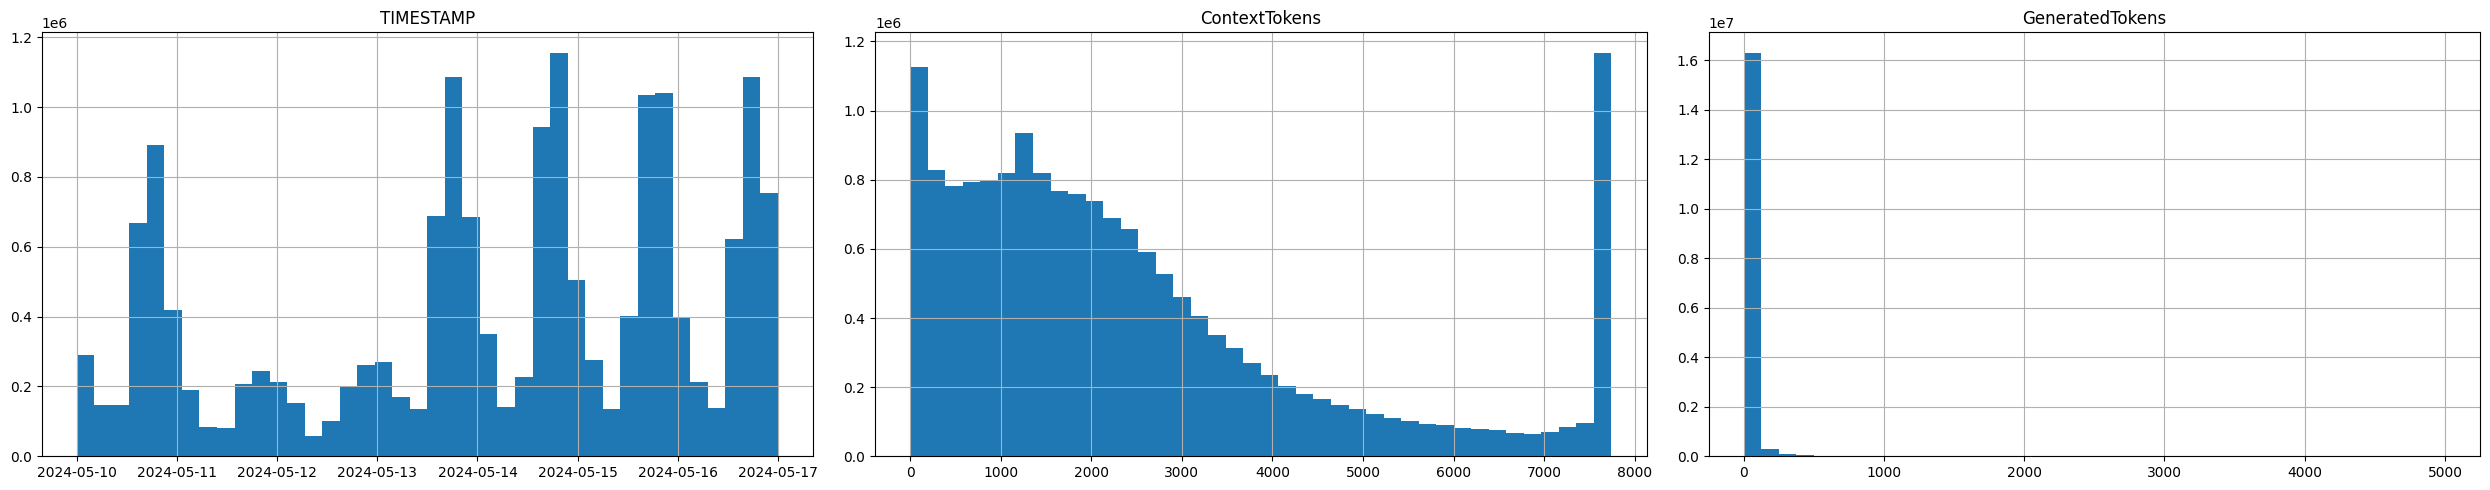

Conversation


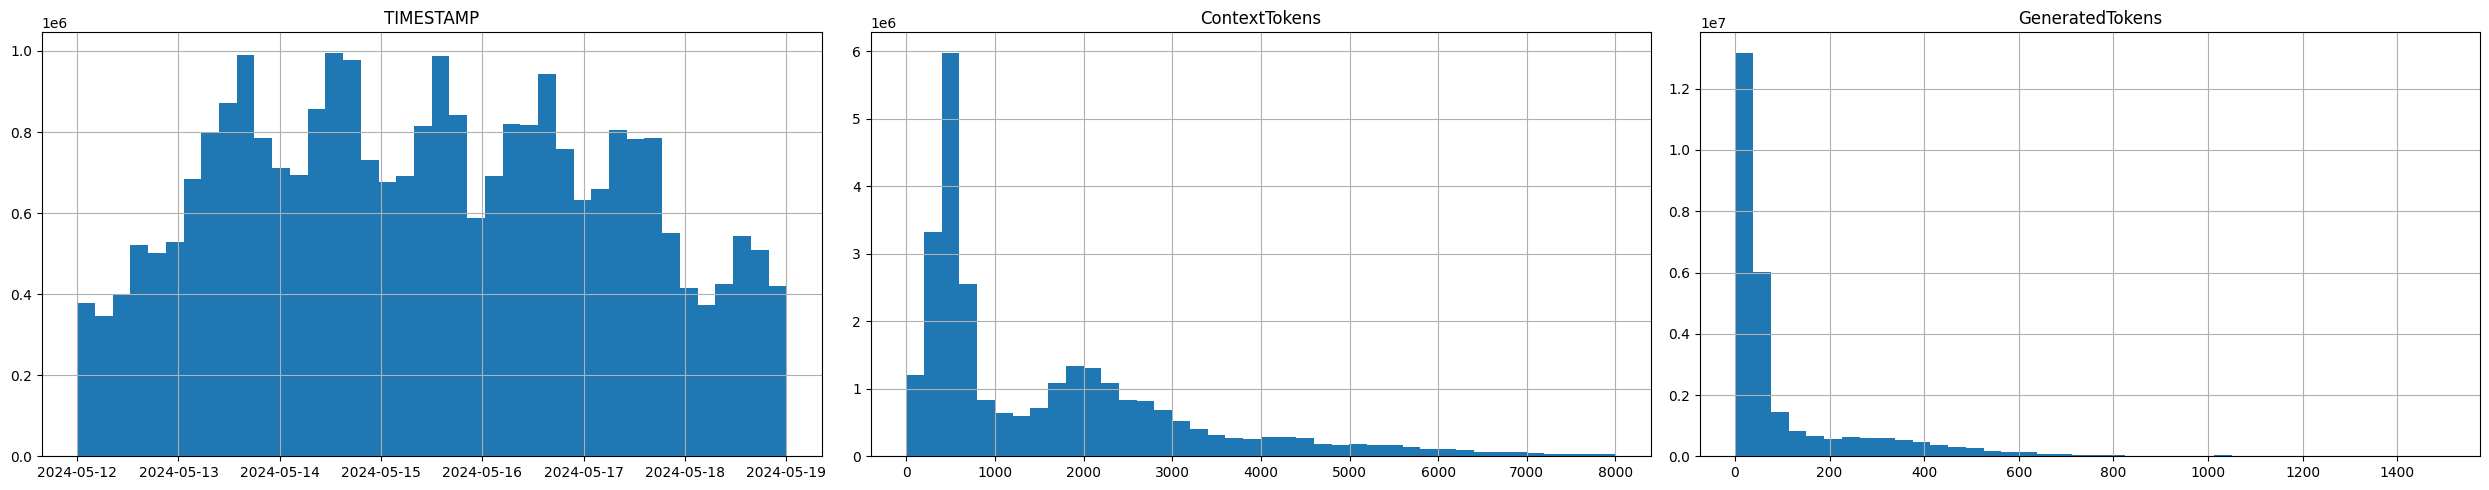

In [7]:
for trace_name, df_trace in df_traces.items():
    print(trace_name)
    df_trace.hist(
        layout=(1, 3),
        figsize=(25, 5),
        bins=40,
    )
    plt.tight_layout()
    plt.show()

## Token distributions

In [8]:
def get_cdf(df, field):
    vals = sorted(df[field].values)
    invs = 100.0 * np.arange(0, len(df)) / len(df)
    return vals, invs

In [9]:
def plt_tokens(dfs, field="ContextTokens", title="Input Tokens"):
    for df_key, df in dfs.items():
        df_tokens, df_inv = get_cdf(df, field)
        plt.plot(df_tokens, df_inv, label=df_key)
    plt.title(title)
    plt.ylabel("CDF")
    plt.xlabel("Number of tokens")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

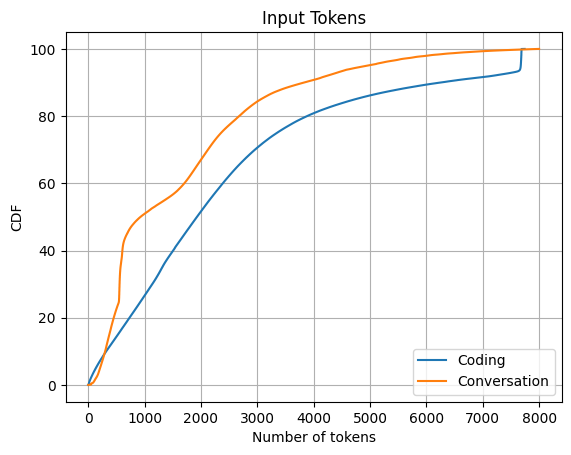

In [10]:
plt_tokens(df_traces, "ContextTokens", "Input Tokens")

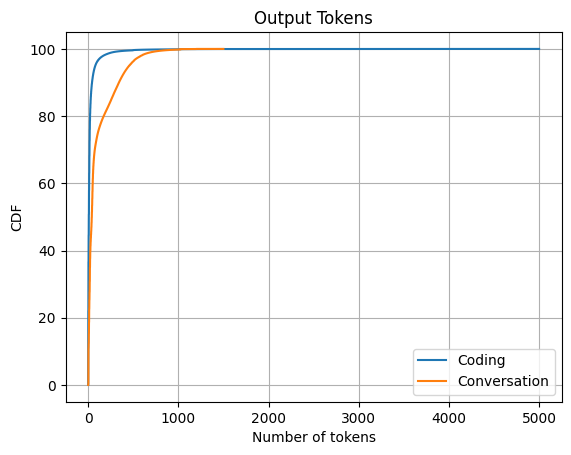

In [11]:
plt_tokens(df_traces, "GeneratedTokens", "Output Tokens")

## Correlation

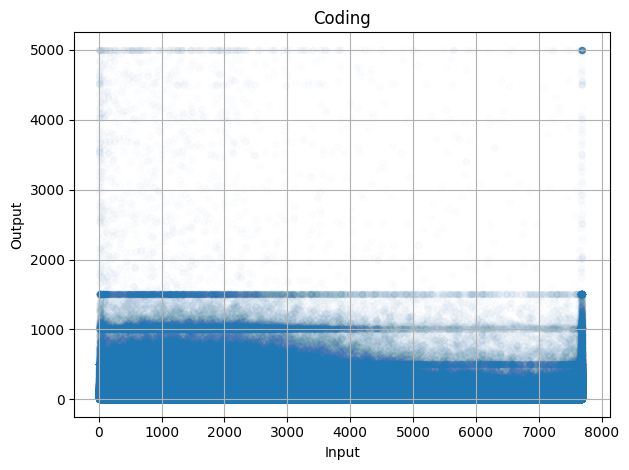

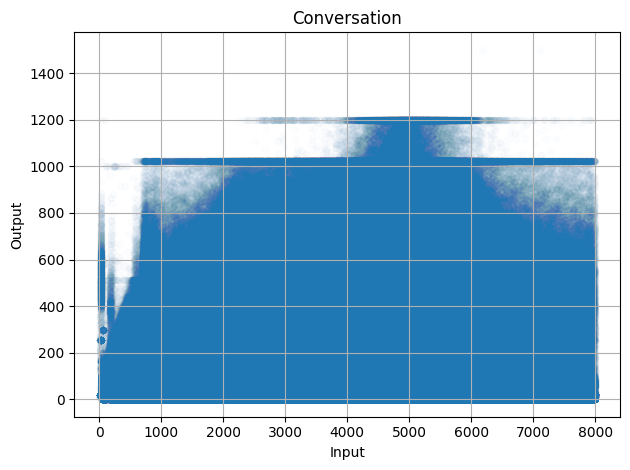

In [12]:
for trace_name, df_trace in df_traces.items():
    df_trace[["ContextTokens", "GeneratedTokens"]].plot.scatter(
        x="ContextTokens",
        y="GeneratedTokens",
        xlabel="Input",
        ylabel="Output",
        alpha=0.01,
        grid=True,
        title=trace_name,
    )
    plt.tight_layout()
    plt.show()

## Analysis over time

In [13]:
def plt_invocations_time(df, figsize=(15, 5)):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy.groupby("Time").count()["TIMESTAMP"].plot(
        grid=True,
        ylim=0,
        figsize=figsize
    )
    plt.ylabel("Number of invocations per minute")
    plt.tight_layout()
    plt.show()

In [14]:
def plt_tokens_time(df, field="ContextTokens", label="Input", show=False):
    df_copy = df.copy()
    df_copy["Time"] = df_copy["TIMESTAMP"].dt.round(freq="min")
    df_copy[["Time", field]].groupby("Time").sum()[field].plot(
        grid=True,
        ylim=0,
        label=label,
    )
    plt.ylabel("Number of tokens per minute")
    plt.legend()
    if show:
        plt.show()

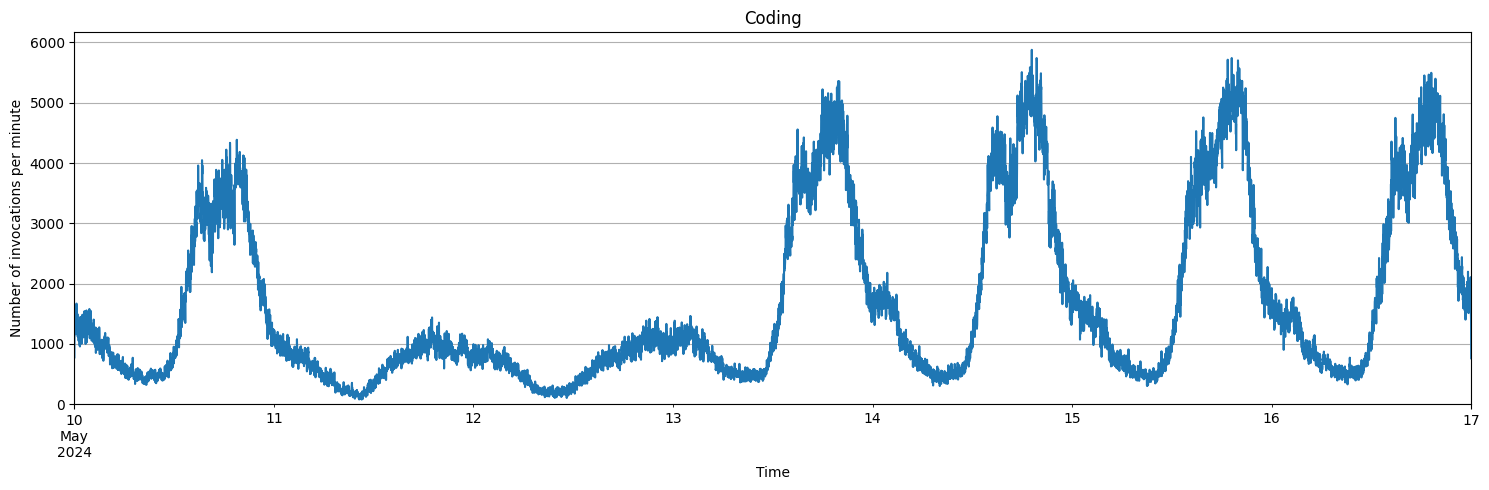

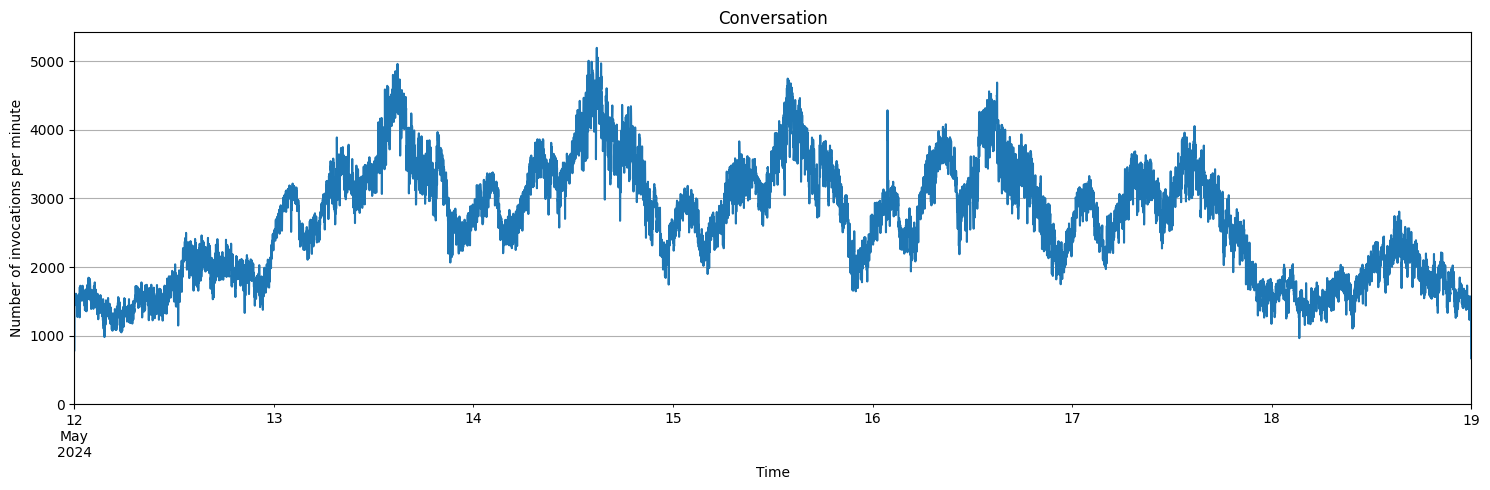

In [15]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_invocations_time(df_trace)

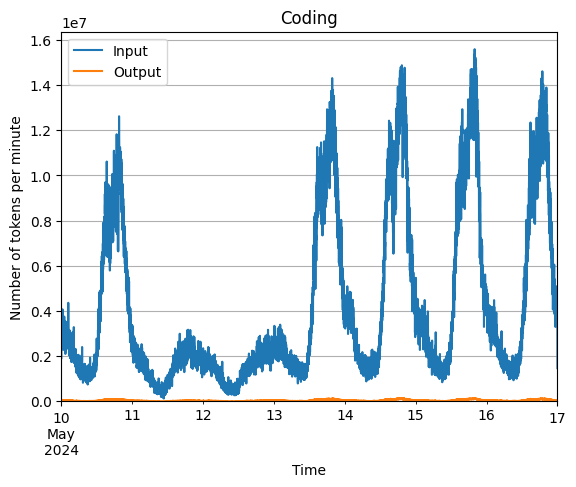

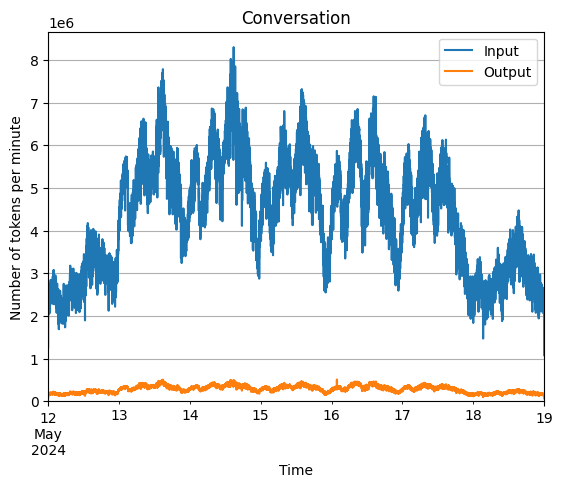

In [16]:
for trace_name, df_trace in df_traces.items():
    plt.title(trace_name)
    plt_tokens_time(df_trace, "ContextTokens", "Input")
    plt_tokens_time(df_trace, "GeneratedTokens", "Output")
    plt.show()

In [17]:
import pandas as pd
from datetime import datetime

# Load one of the datasets (you can repeat for both)
df_code = pd.read_csv("/Users/sathwik/VISUAL STUDIO CODE/Cloud:Fog/Azure LLM Inference Dataset/data2024/AzureLLMInferenceTrace_code_1week.csv", parse_dates=["TIMESTAMP"])
df_code["TotalTokens"] = df_code["ContextTokens"] + df_code["GeneratedTokens"]

# Optional: Resample to minute-wise or second-wise request load
df_code.set_index("TIMESTAMP", inplace=True)
token_load = df_code["TotalTokens"].resample("1min").sum().reset_index()
token_load.columns = ["Timestamp", "TotalTokens"]

In [18]:
# Create features: previous 5 mins token load
for i in range(1, 6):
    token_load[f"lag_{i}"] = token_load["TotalTokens"].shift(i)

# Drop NaNs caused by shifting
token_load.dropna(inplace=True)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = token_load[[f"lag_{i}" for i in range(1, 6)]]
y = token_load["TotalTokens"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict server load for next timestamp
y_pred = model.predict(X_test)

In [20]:
import numpy as np

# Simulated rolling server loads
server_loads = [0, 0, 0]
assignments = []

for val in y_pred:
    chosen_server = np.argmin(server_loads)
    assignments.append(chosen_server)
    server_loads[chosen_server] += val  # add this token load

In [21]:
print("Final server loads:", server_loads)
print("Load standard deviation:", np.std(server_loads))

Final server loads: [np.float64(2763917100.4500027), np.float64(2762228094.0400014), np.float64(2767558583.989999)]
Load standard deviation: 2224291.850657488


AI-Based Load Balancer: Result Interpretation

✅ Final Server Loads:
	•	Server 0: 2.76B tokens
	•	Server 1: 2.76B tokens
	•	Server 2: 2.77B tokens

These values are very close to each other, which is excellent — it shows that your AI-driven routing algorithm distributed the load quite evenly across all servers.

⸻

📉 Load Standard Deviation: ~2.22M tokens
	•	In context of total loads nearing 2.76B, a std dev of ~0.08% shows high load balance efficiency.
	•	This low deviation means no server is overloaded compared to others — a major win for latency and resource utilization.

In [24]:
import pandas as pd

df_conv = pd.read_csv("/Users/sathwik/VISUAL STUDIO CODE/Cloud:Fog/Azure LLM Inference Dataset/data2024/AzureLLMInferenceTrace_conv_1week.csv")

# Fix: Let pandas handle mixed formats
df_conv["TIMESTAMP"] = pd.to_datetime(df_conv["TIMESTAMP"], format='mixed')

df_conv["TotalTokens"] = df_conv["ContextTokens"] + df_conv["GeneratedTokens"]
df_conv.set_index("TIMESTAMP", inplace=True)

token_load = df_conv["TotalTokens"].resample("1min").sum().reset_index()
token_load.columns = ["Timestamp", "TotalTokens"]

In [25]:
# Create lag features for the past 5 minutes
for i in range(1, 6):
    token_load[f"lag_{i}"] = token_load["TotalTokens"].shift(i)

# Drop rows with missing values due to lag
token_load.dropna(inplace=True)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Features: previous 5 minutes
X = token_load[[f"lag_{i}" for i in range(1, 6)]]
y = token_load["TotalTokens"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict future loads
y_pred = model.predict(X_test)

In [27]:
import numpy as np

server_loads = [0, 0, 0]
assignments = []

for load in y_pred:
    chosen_server = np.argmin(server_loads)  # choose the least loaded
    assignments.append(chosen_server)
    server_loads[chosen_server] += load

In [28]:
print("Final server loads:", server_loads)
print("Standard deviation across servers:", np.std(server_loads))

Final server loads: [np.float64(3150570949.540001), np.float64(3149845199.5800023), np.float64(3153555189.490001)]
Standard deviation across servers: 1605422.2779868816


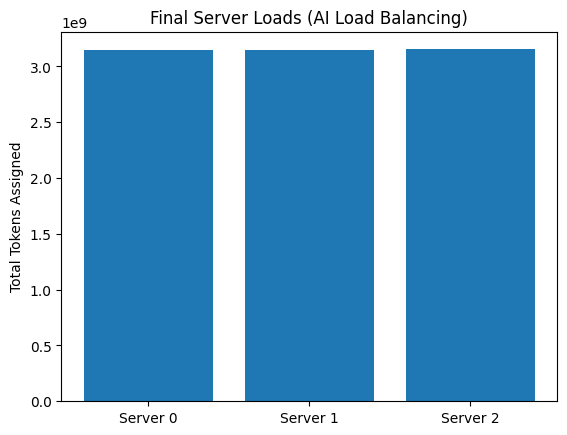

In [29]:
import matplotlib.pyplot as plt

plt.bar(["Server 0", "Server 1", "Server 2"], server_loads)
plt.ylabel("Total Tokens Assigned")
plt.title("Final Server Loads (AI Load Balancing)")
plt.show()

In [30]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 MB 30.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 62.9 MB/s eta 0:00:0000:0100:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.5/671.5 kB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 56.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 55.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 62.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 71.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.9 MB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
     ━━━━━━━━━━━━━━━━━━━